In [20]:
#copy from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook (코드 원본 경로)

* imports

In [2]:
# !pip install imgaug

In [1]:
import os                                                                   #파일 및 디렉토리 조작 등 운영체제와의 상호작용을 위한 기능

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt                                             #그래프와 차트 같은 시각화 라이브러리
import matplotlib.image as mpimg                                            #이미지를 읽고 표시하는 기능

import xml.etree.ElementTree as ET                                          #XML 데이터를 파싱하고 생성하는 모듈. 컴퓨터 비전 데이터셋에서 주석(annotation) 정보를 처리할 때 유용

import numpy as np
np.bool = bool
import pandas as pd

from skimage.io import imread                                               #이미지를 배열 형태로 읽어오는 함수로, 머신러닝 모델에 데이터를 공급
from skimage.transform import resize                                        #이미지를 원하는 크기로 조정하는 기능으로, 모델 입력 차원에 맞추기 위해 필요
from PIL import Image                                                       #고급 이미지 조작을 위해 사용되는 Python Imaging Library(PIL)의 일부
from imgaug import augmenters as iaa                                        #이미지 증강 라이브러리. augmenters as iaa는 회전, 뒤집기 등의 다양한 증강 기법을 제공해 학습 데이터 다양성을 높이는 데 유용

from sklearn.model_selection import train_test_split                        #데이터셋 분할

from keras.models import *                                                  #딥러닝 모델 구조를 정의
from keras.layers import *                                                  #신경망을 구축할 때 필요한 레이어들을 제공
from keras.layers import Input
from keras.optimizers import *                                              #SGD, Adam 등 다양한 최적화 알고리즘을 포함
from keras.utils import to_categorical                                      #원-핫 인코딩과 같은 유틸리티 기능을 포함
from tensorflow.keras.utils import Sequence                                 #데이터 생성기(generator)를 만드는 데 자주 사용. 배치 단위로 데이터가 순서대로 생성되며, 병렬 처리나 멀티 프로세싱에도 적합   
from keras.callbacks import *                                               #학습 중 모델을 모니터링하고 저장하는 데 필요한 기능

from tensorflow.keras.applications import ResNet50                         # ResNet50 임포트
from keras.applications.densenet import DenseNet121, preprocess_input      #DenseNet121: 사전 학습된 DenseNet 모델 중 하나로, 이미지 분류에서 전이 학습을 위해 자주 사용
                                                                           #preprocess_input: DenseNet121 학습에 사용된 형식으로 입력 이미지를 정규화

In [2]:
# 성능평가를 위한 추가 임포트 
from sklearn.metrics import classification_report, confusion_matrix  # 1. Classification Report (정밀도, 재현율, F1 점수 포함)
import seaborn as sns   # 2. Confusion Matrix (혼동 행렬)

* how many breeds and pictures we have

In [3]:
# 데이터셋 경로 설정 및 정보 출력

#종 수, 이미지 수
breed_list = os.listdir(r"C:\project\100.Project\11.1차프로젝트\01.견종판별\archive\images\Images")            #지정된 디렉터리 내의 파일과 폴더 목록을 반환하여 저장
num_classes = len(breed_list)                                                         
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(r"C:\project\100.Project\11.1차프로젝트\01.견종판별\archive\images\Images\{}".format(breed)))
print("{} images".format(n_total_images))

121 breeds
20690 images


* label strings and numbers mapping

In [4]:
# 데이터 경로 및 레이블 설정

#label strings and numbers mapping   종속변수 데이터를 숫자와 맵핑함


label_maps = {}                     #딕셔너리로 저장
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})       #품종 이름을 키(key)로, 해당 품종의 레이블 숫자를 값(value)으로 저장
    label_maps_rev.update({i : v})  #품종의 레이블 숫자를 키로, 품종 이름을 값으로 저장

In [5]:
len(label_maps_rev)

121

In [6]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

In [7]:
paths, labels, targets = paths_and_labels()
print(paths)    
print(labels)    
print(targets)
#각각의 데이터들 갯수 확인
len(paths), len(labels), len(targets)

['./data/n02085620-Chihuahua/n02085620_10074.jpg', './data/n02085620-Chihuahua/n02085620_10131.jpg', './data/n02085620-Chihuahua/n02085620_10621.jpg', './data/n02085620-Chihuahua/n02085620_1073.jpg', './data/n02085620-Chihuahua/n02085620_10976.jpg', './data/n02085620-Chihuahua/n02085620_11140.jpg', './data/n02085620-Chihuahua/n02085620_11238.jpg', './data/n02085620-Chihuahua/n02085620_11258.jpg', './data/n02085620-Chihuahua/n02085620_11337.jpg', './data/n02085620-Chihuahua/n02085620_11477.jpg', './data/n02085620-Chihuahua/n02085620_1152.jpg', './data/n02085620-Chihuahua/n02085620_11696.jpg', './data/n02085620-Chihuahua/n02085620_11818.jpg', './data/n02085620-Chihuahua/n02085620_11948.jpg', './data/n02085620-Chihuahua/n02085620_1205.jpg', './data/n02085620-Chihuahua/n02085620_12101.jpg', './data/n02085620-Chihuahua/n02085620_12334.jpg', './data/n02085620-Chihuahua/n02085620_1235.jpg', './data/n02085620-Chihuahua/n02085620_1271.jpg', './data/n02085620-Chihuahua/n02085620_12718.jpg', './d

(20690, 20690, 20690)

In [8]:
# 타겟을 원-핫 인코딩

#targets 리스트의 정수형 값들을 범주형 데이터로 변환하여 딥러닝 모델에 입력할 수 있게 만듦. to_categorical 함수는 각 타겟 값이 num_classes 차원의 원-핫 인코딩된 벡터로 변환
targets = to_categorical(targets, 121)
print(targets)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


* image generator with augment

In [9]:
# 데이터 분할 및 배치 생성

batch_size = 32

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image




* train test split

In [10]:
#이미지 데이터를 학습 및 검증 세트로 나누고, 각 세트에서 배치 단위로 데이터를 생성할 수 있도록 ImageGenerator라는 클래스를 사용

#전체 이미지가 1200개, 15%인 약 180개가 검증 세트(val_gen)로 할당, 나머지 약 1020개가 학습 세트(train_gen)로 할당
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, targets, test_size=0.15, random_state=1029)

train_gen = ImageGenerator(train_paths,       # train_paths / train_targets: 학습 세트 이미지 경로와 레이블
                           train_targets,     
                           batch_size=64,     # 배치 크기 32로 설정하여 한 번에 32개의 이미지를 처리 
                           shape=(224,224,3), # 각 이미지의 크기를 (224, 224, 3)으로 리사이즈. (224x224 해상도, RGB 채널 포함)
                           augment=True)      # 학습 데이터 생성기에서만 데이터 증강을 활성화하여 모델이 다양한 데이터로 학습할 수 있도록 함
val_gen = ImageGenerator(val_paths,           # val_paths / val_targets: 검증 세트 이미지 경로와 레이블
                         val_targets, 
                         batch_size=64, 
                         shape=(224,224,3), 
                         augment=False)      # 검증 데이터는 증강하지 않고 원본 이미지 그대로 사용

## 성능평가지표

In [ ]:
# [절대경로]
# # 모델 불러오기
# loaded_model = load_model('C:/project/100.Project/11.1차프로젝트/01.견종판별/dense/final_dog_breed_model.keras')


In [11]:
#[상대경로]
# from keras.models import load_model
# import os

# 모델 경로 생성
model_path = os.path.join('.', 'dense', 'final_dog_breed_model_121_v3.keras')

# 모델 로드
loaded_model = load_model(model_path)

In [12]:
# 예측 생성
val_preds = loaded_model.predict(val_gen)
val_pred_labels = np.argmax(val_preds, axis=1)
val_true_labels = np.argmax(val_targets, axis=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 46s 902ms/step


In [13]:
# 1. Classification Report (정밀도, 재현율, F1 점수 포함)
print("Classification Report")
print(classification_report(val_true_labels, val_pred_labels, target_names=breed_list))

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.57      0.67      0.62        18
              n02085782-Japanese_spaniel       0.83      0.83      0.83        24
                   n02085936-Maltese_dog       0.84      0.79      0.81        47
                      n02086079-Pekinese       0.89      0.73      0.80        22
                      n02086240-Shih-Tzu       0.76      0.76      0.76        37
              n02086646-Blenheim_spaniel       0.78      0.93      0.85        27
                      n02086910-papillon       0.89      0.89      0.89        28
                   n02087046-toy_terrier       0.75      0.56      0.64        27
           n02087394-Rhodesian_ridgeback       0.38      0.44      0.41        18
                  n02088094-Afghan_hound       0.90      1.00      0.95        35
                        n02088238-basset       0.81      0.81      0.81    

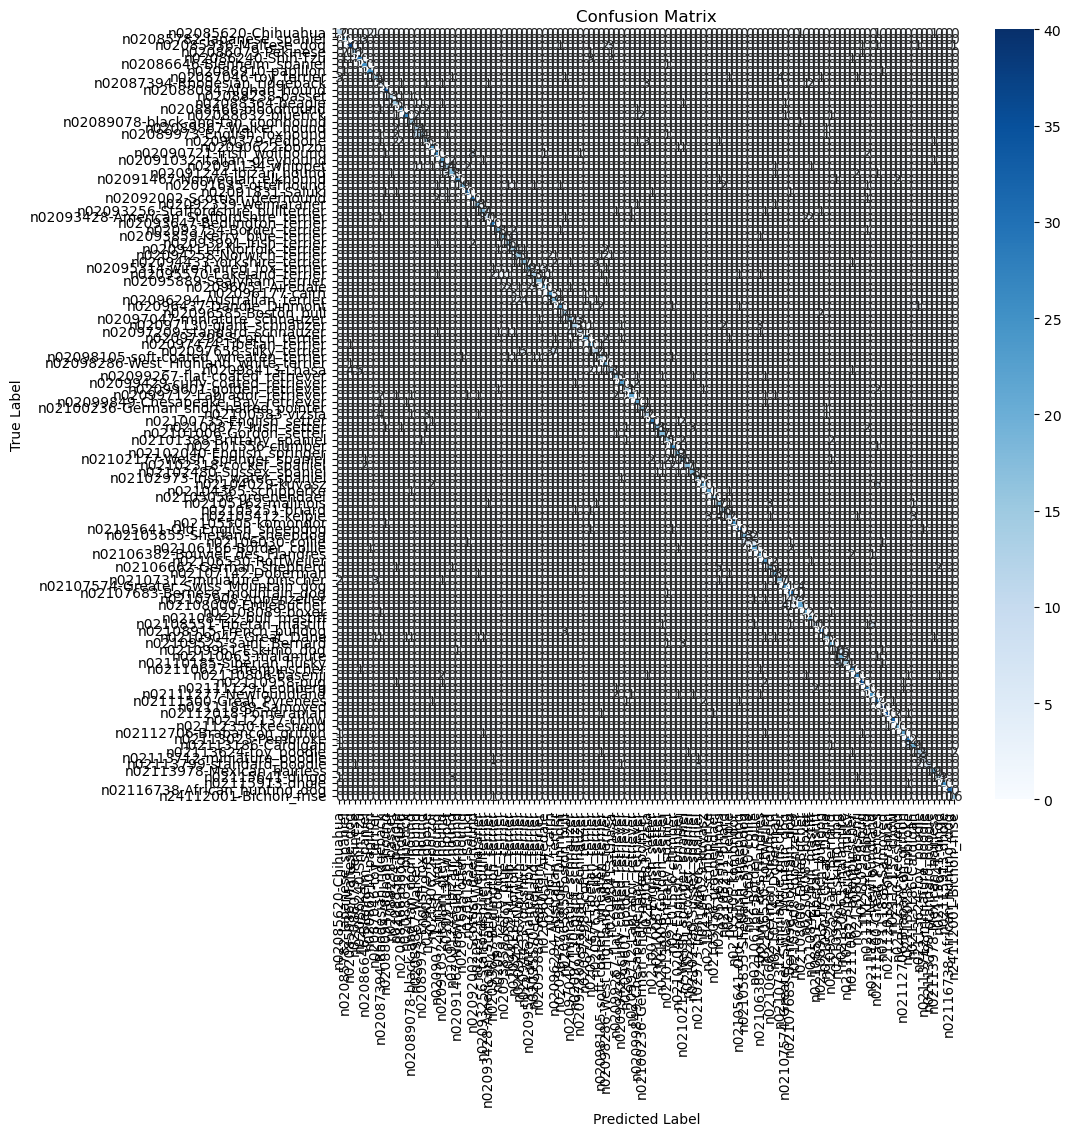

In [14]:
# 2. Confusion Matrix (혼동 행렬)
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=breed_list, yticklabels=breed_list)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

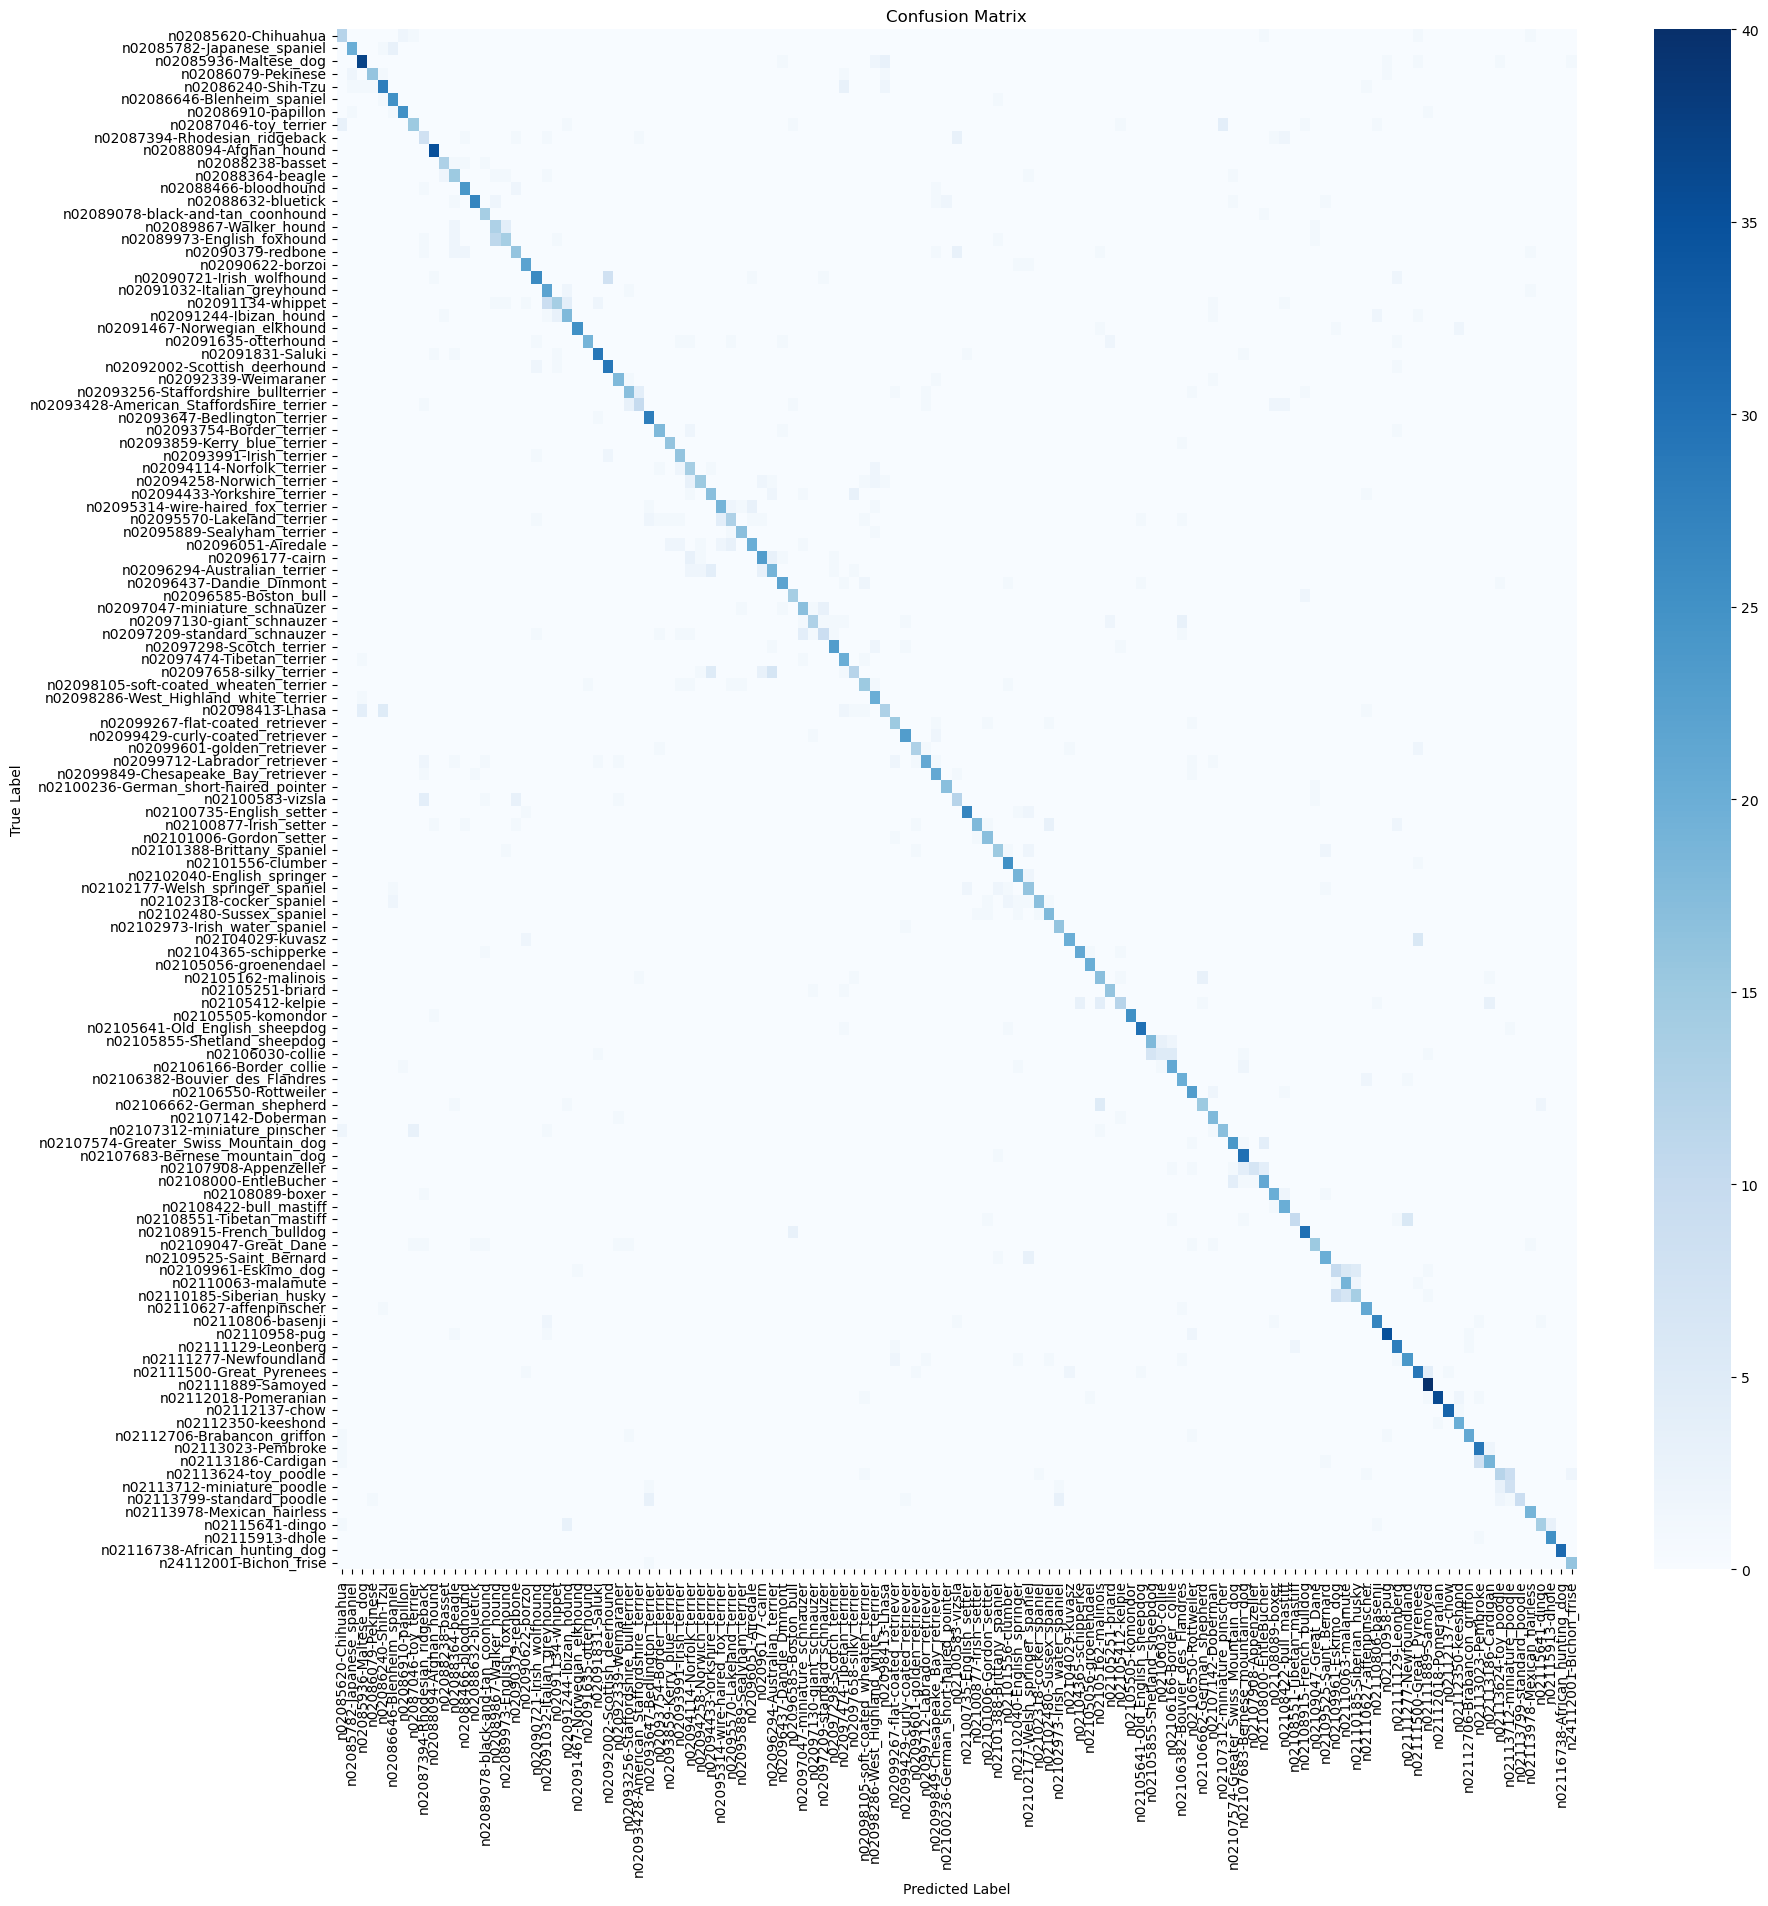

In [15]:
# 그래프 수정 [최종]
cm = confusion_matrix(val_true_labels, val_pred_labels)
plt.figure(figsize=(20,20))  # 그래프 크기 조정
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=breed_list, yticklabels=breed_list)
plt.xticks(rotation=90)  # X축 라벨 회전
plt.yticks(rotation=0)   # Y축 라벨 회전
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1. Bar Plot (막대 그래프)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

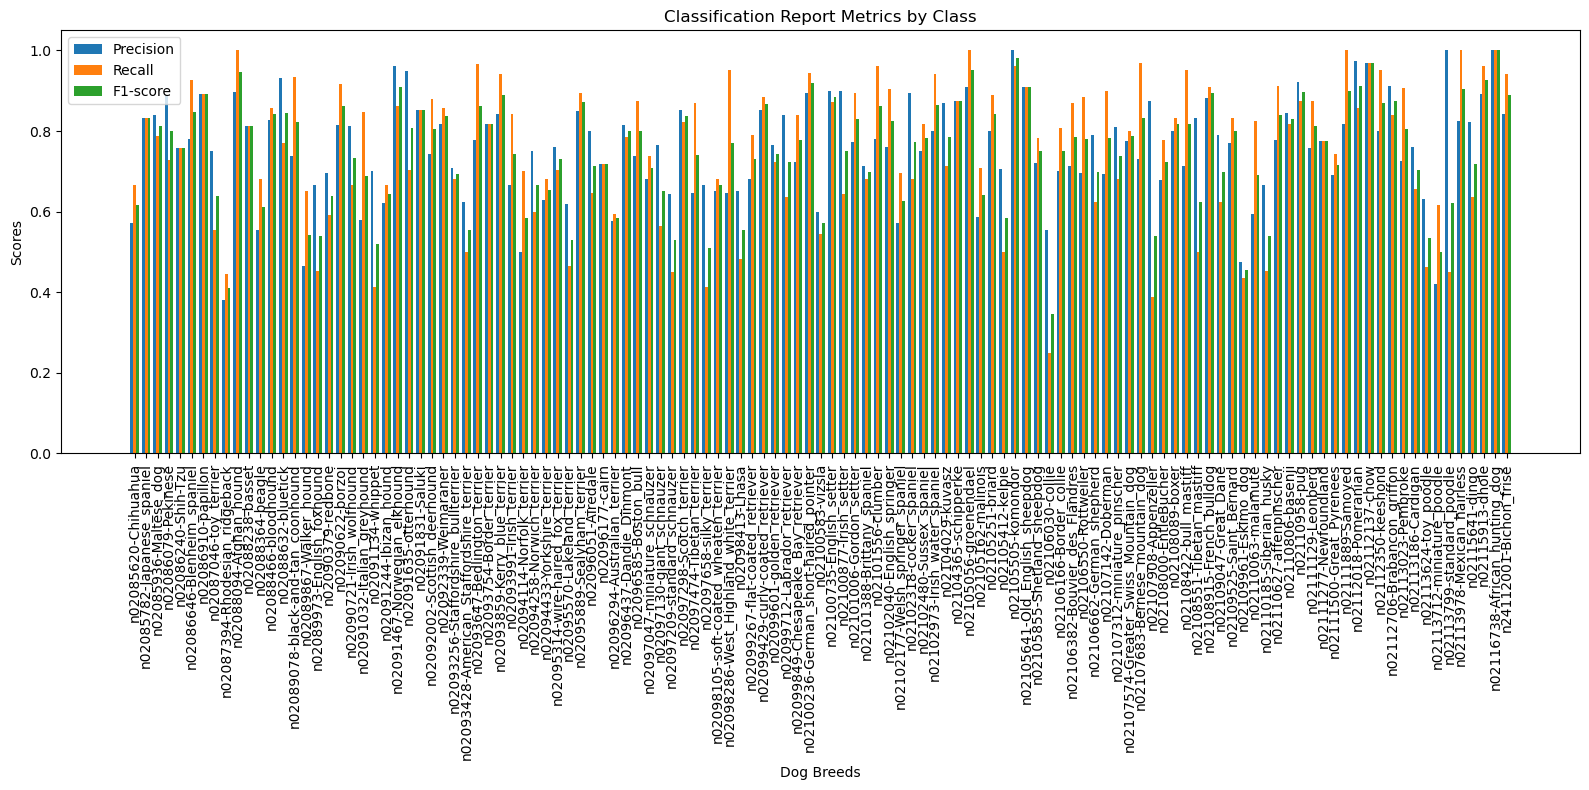

In [17]:
# Classification Report 데이터를 pandas DataFrame으로 변환
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(val_true_labels, val_pred_labels, target_names=breed_list, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Precision, Recall, F1-Score 시각화
df_report = df_report[:-3]  # 마지막 3개의 행은 전체 평균 값이므로 제외
classes = df_report.index.tolist()
precision = df_report['precision'].values
recall = df_report['recall'].values
f1_score = df_report['f1-score'].values

x = np.arange(len(classes))  # X축 위치
width = 0.25  # 막대 폭

plt.figure(figsize=(16, 8))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-score')

plt.xlabel('Dog Breeds')
plt.ylabel('Scores')
plt.title('Classification Report Metrics by Class')
plt.xticks(x, classes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import imageio.v2 as imageio  # imageio의 v2를 명시적으로 사용  : imageio 라이브러리의 최신 버전에서 권장하는 방식으로 수정

In [19]:
# label_maps_rev.npy 파일 불러오기
label_maps_rev = np.load('label_maps_rev.npy', allow_pickle=True).item()

In [20]:
# 최종 모델 불러오기
model = load_model('./dense/final_dog_breed_model_121_v3.keras')

In [21]:
def download_and_predict(url, filename):
    # 이미지 다운로드 및 저장
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    
    # 이미지 표시
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    
    # 예측
    img = imageio.imread(filename)  # imageio.v2를 사용하여 경고 제거
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    
    # 예측 결과 출력
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
49.74% 	 malinois
31.26% 	 dhole
10.09% 	 dingo
5.77% 	 German_shepherd
1.59% 	 kelpie


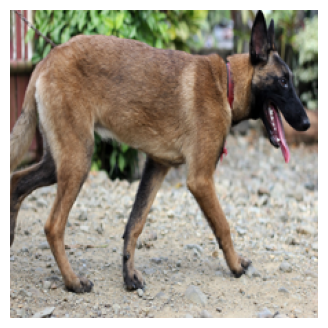

In [22]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
98.34% 	 Pembroke
0.92% 	 Cardigan
0.41% 	 dingo
0.06% 	 dhole
0.04% 	 collie


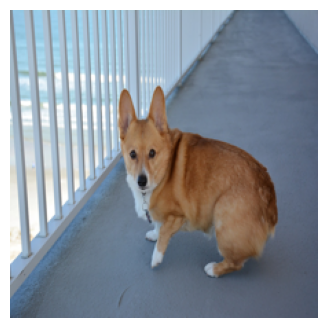

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
88.80% 	 Chihuahua
7.60% 	 toy_terrier
3.26% 	 miniature_pinscher
0.10% 	 Boston_bull
0.06% 	 basenji


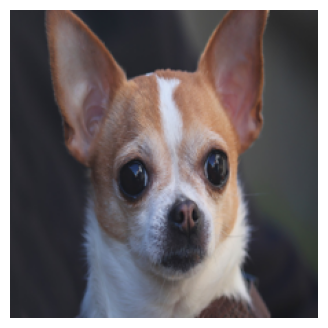

In [24]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
33.51% 	 redbone
21.21% 	 Weimaraner
20.46% 	 vizsla
18.41% 	 Rhodesian_ridgeback
1.44% 	 bloodhound


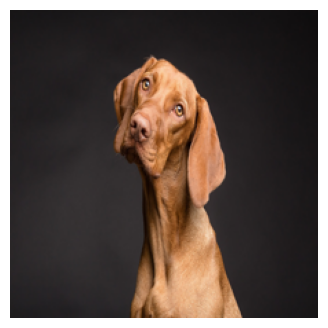

In [25]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
49.87% 	 Labrador_retriever
22.39% 	 golden_retriever
9.71% 	 Rhodesian_ridgeback
3.95% 	 bull_mastiff
2.96% 	 Chesapeake_Bay_retriever


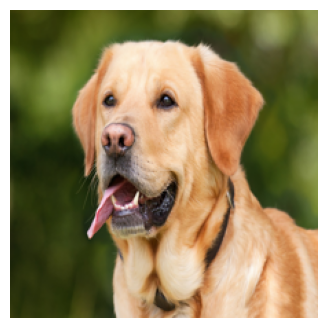

In [26]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
58.77% 	 miniature_poodle
21.65% 	 toy_poodle
14.93% 	 Bichon_frise
3.21% 	 standard_poodle
0.65% 	 Dandie_Dinmont


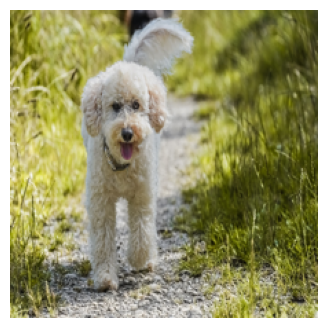

In [27]:
download_and_predict("https://cdn.pixabay.com/photo/2022/07/12/17/12/dog-7317820_1280.jpg", "test_6.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
52.50% 	 Maltese_dog
30.42% 	 Tzu
16.81% 	 Lhasa
0.14% 	 Pekinese
0.06% 	 Bichon_frise


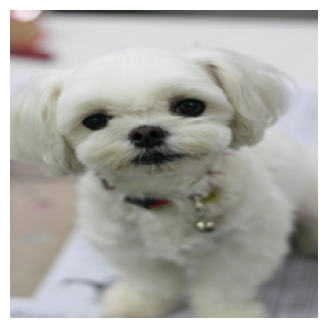

In [28]:
download_and_predict("https://cdn.pixabay.com/photo/2022/04/15/10/26/dog-7134077_1280.jpg", "test_7.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
63.84% 	 miniature_poodle
31.32% 	 toy_poodle
3.16% 	 Bichon_frise
1.64% 	 standard_poodle
0.02% 	 Maltese_dog


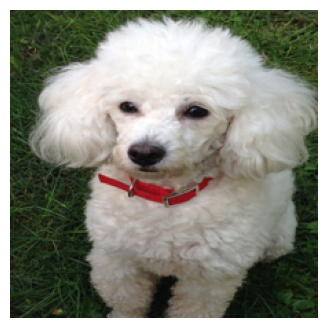

In [29]:


download_and_predict("https://i.pinimg.com/736x/29/c9/a1/29c9a134f91103af59fca8fed7220eaf.jpg", "test_9.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
91.47% 	 Bichon_frise
3.21% 	 toy_poodle
2.05% 	 Maltese_dog
1.57% 	 miniature_poodle
0.33% 	 Old_English_sheepdog


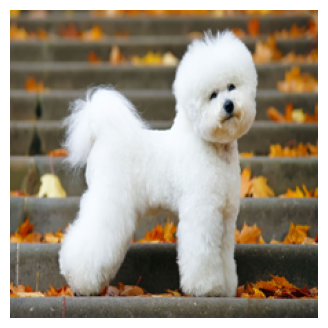

In [35]:
download_and_predict("https://cdn.britannica.com/54/236454-050-B406A11E/Bichon-frise-dog.jpg", "test_11.jpg")

In [30]:
print("Keys in label_maps_rev:", sorted(label_maps_rev.keys()))

Keys in label_maps_rev: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]


In [31]:
print("Breed List:", breed_list)


Breed List: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433

In [32]:
label_maps_rev = {i: breed for i, breed in enumerate(breed_list)}
np.save("label_maps_rev.npy", label_maps_rev)

In [33]:
label_maps_rev = np.load("label_maps_rev.npy", allow_pickle=True).item()

In [34]:
print("Keys in label_maps_rev:", sorted(label_maps_rev.keys()))

Keys in label_maps_rev: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
